In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
orientation = ["LEADING", "LAGGING"]

In [3]:
class Gene:
    def __init__(self, length, orientation, basal_expression, intergene):
        self.length = length                      # Length of the coding sequence                  
        self.intergene = intergene                # Distance to the next gene
        self.orientation = orientation            # Leading or lagging strand
        self.basal_expression = basal_expression  # Initial expression level
        
    def __repr__(self):
        return f'{self.length}, {self.intergene}, {orientation[self.orientation]}, {self.basal_expression}'

In [4]:
# Make an initial list of genes
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [5]:
def generate_genes(nb_genes, gene_length, intergene):
    genes = []

    for gene in range(nb_genes):
        new_gene = Gene(length=gene_length,
                        intergene=intergene,
                        orientation=np.random.randint(2),
                        basal_expression=np.random.random()) 
        genes.append(new_gene)

    return genes

In [6]:
def compute_positions(genes):
    nb_genes = len(genes)
    positions = np.zeros(nb_genes, dtype=int)
    cur_pos = 0
        
    for i_gene, gene in enumerate(genes):
        positions[i_gene] = cur_pos
        cur_pos += gene.length + gene.intergene
        
    return positions

In [7]:
def interaction(genes, positions, i_1, i_2):
    # calcul de l'influence de la transcription du gène 2 sur le gène 1    
    
    if i_1 == i_2: # It's the same gene
        return 1.0
    
        
    pos_1 = positions[i_1]
    pos_2 = positions[i_2]
    
    ## On veut savoir si le gène 1 est avant le gène 2 ou après
    # Avant : -------1--2-------- ou -2---------------1-
    # Après : -------2--1-------- ou -1---------------2-
    
    if pos_1 < pos_2: # -------1--2-------- ou -1---------------2-
        if pos_2 - pos_1 < genome_size + pos_1 - pos_2: # -------1--2--------
            distance = pos_2 - pos_1
            is_before = True
        else: # -1---------------2-
            distance = genome_size + pos_1 - pos_2
            is_before = False
            
    else: # -------2--1-------- ou -2---------------1-
        if pos_1 - pos_2 < genome_size + pos_2 - pos_1: # -------2--1--------
            distance = pos_1 - pos_2
            is_before = False
        else:
            distance = genome_size + pos_2 - pos_1
            is_before = True
    
    ## Orientations relatives
    if (is_before and genes[i_2].orientation == 0) or (not is_before and genes[i_2].orientation == 1):
        sign = +1
    else:
        sign = -1
                            
    strength = max(1 - distance/interaction_dist, 0)
                
    return sign * strength

In [8]:
def make_inter_matrix(genes):
    nb_genes = len(genes)
    inter_matrix = np.zeros((nb_genes, nb_genes))
    
    positions = compute_positions(genes)
    
    for i in range(nb_genes):
        for j in range(nb_genes):
            inter_matrix[i, j] = interaction(genes, positions, i, j)
    
    return inter_matrix

In [9]:
def run_system(inter_matrix, init_expr, nb_steps):
    nb_genes = len(init_expr)
    temporal_expr = np.zeros((nb_genes, nb_steps))
    
    # Initial values at t = 0
    temporal_expr[:, 0] = init_expr.copy()
    
    #print(f'time 0: temporal_expr: {temporal_expr[:, 0]}')
    
    # Iterate the system
    for t in range(1, nb_steps):
        temporal_expr[:, t] = inter_matrix @ temporal_expr[:, t-1]
        temporal_expr[:, t] = np.maximum(temporal_expr[:, t], 0)
        temporal_expr[:, t] = np.minimum(temporal_expr[:, t], 2)
        #print(f'time {t}: temporal_expr: {temporal_expr[:, t]}')

        
    return temporal_expr

In [10]:
def compute_fitness(expr_levels):
    # On renvoie la somme des valeurs moyennes d'expression sur les 5 derniers pas de temps 
    avg_steps = 5
    nb_genes, nb_steps = expr_levels.shape
    return np.mean(expr_levels[:, nb_steps-avg_steps:])

In [11]:
def run_individual(genes, nb_steps):
    inter_matrix = make_inter_matrix(genes)
    init_levels = np.array([gene.basal_expression for gene in genes])
    time_levels = run_system(inter_matrix, init_levels, nb_steps)
    
    fitness = compute_fitness(time_levels)
    
    return time_levels, fitness

In [12]:
def plot_expr(temporal_expr, fitness, plot_name):
    nb_genes, nb_steps = temporal_expr.shape
    
    #colormap = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    
    plt.figure(figsize=(9, 6), dpi=200)
    
    for gene in range(nb_genes):
        linestyle = 'solid' if genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[gene, :],
                 linestyle=linestyle,
                 #color=colormap[gene],
                 label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    plt.legend(loc='center right')
    plt.title(f'Fitness: {fitness:.2}')
        
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')

In [13]:
genes = generate_genes(nb_genes=10, gene_length=gene_length, intergene=intergene)

In [14]:
res, fitness = run_individual(genes, 16)

In [15]:
fitness

0.41461495302924917

In [16]:
compute_fitness(res)

0.41461495302924917

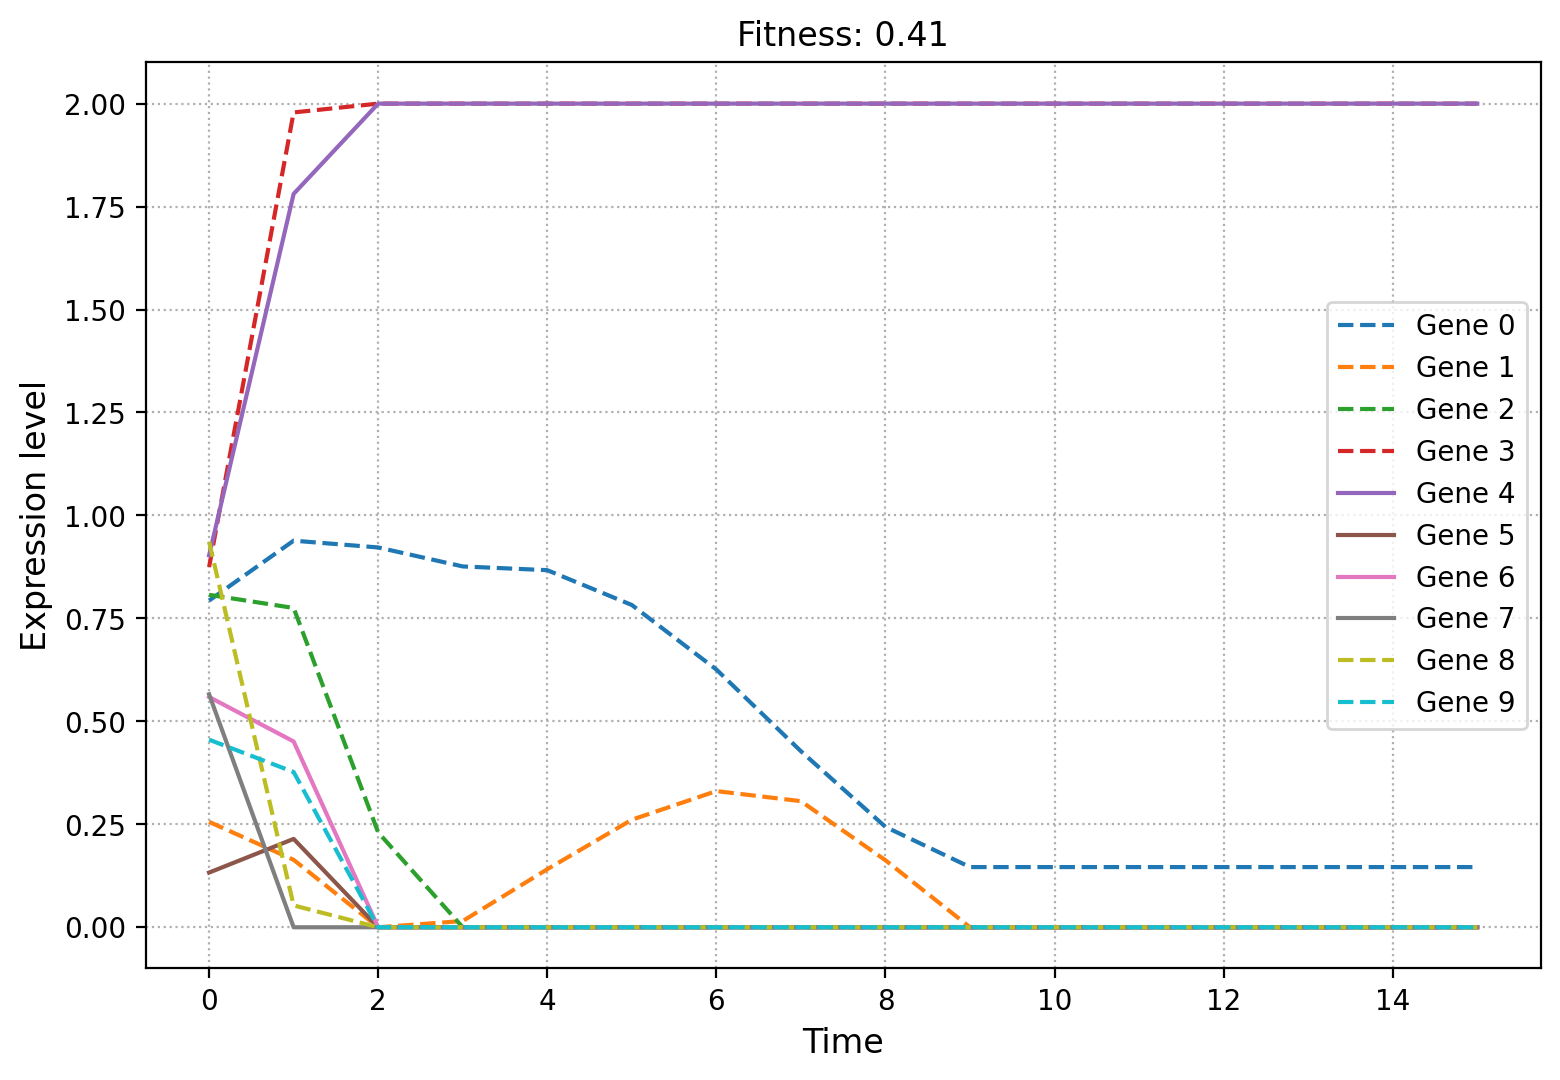

In [17]:
plot_expr(res, fitness, 'baseline')

Switched gene 0, fitness: 0.8
Switched gene 1, fitness: 0.8
Switched gene 2, fitness: 0.8
Switched gene 3, fitness: 0.4294277072741228
Switched gene 4, fitness: 0.4
Switched gene 5, fitness: 0.41461495302924917
Switched gene 6, fitness: 0.44069254084726805
Switched gene 7, fitness: 0.4
Switched gene 8, fitness: 0.4269201556730485
Switched gene 9, fitness: 0.8


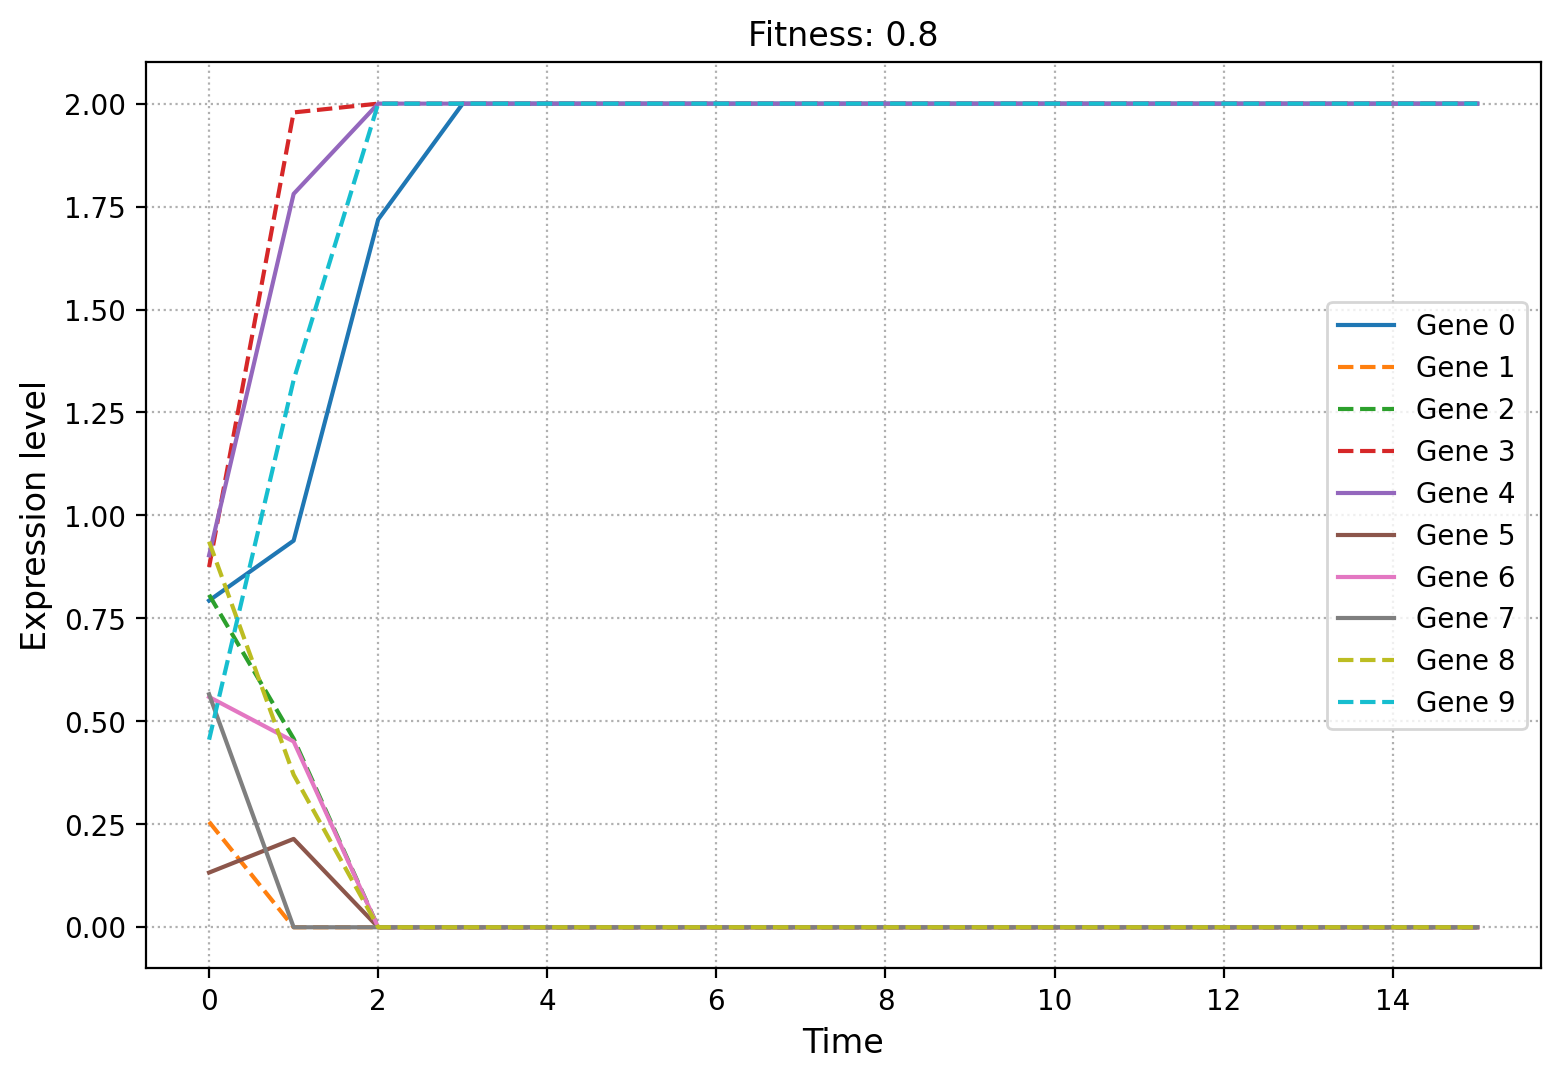

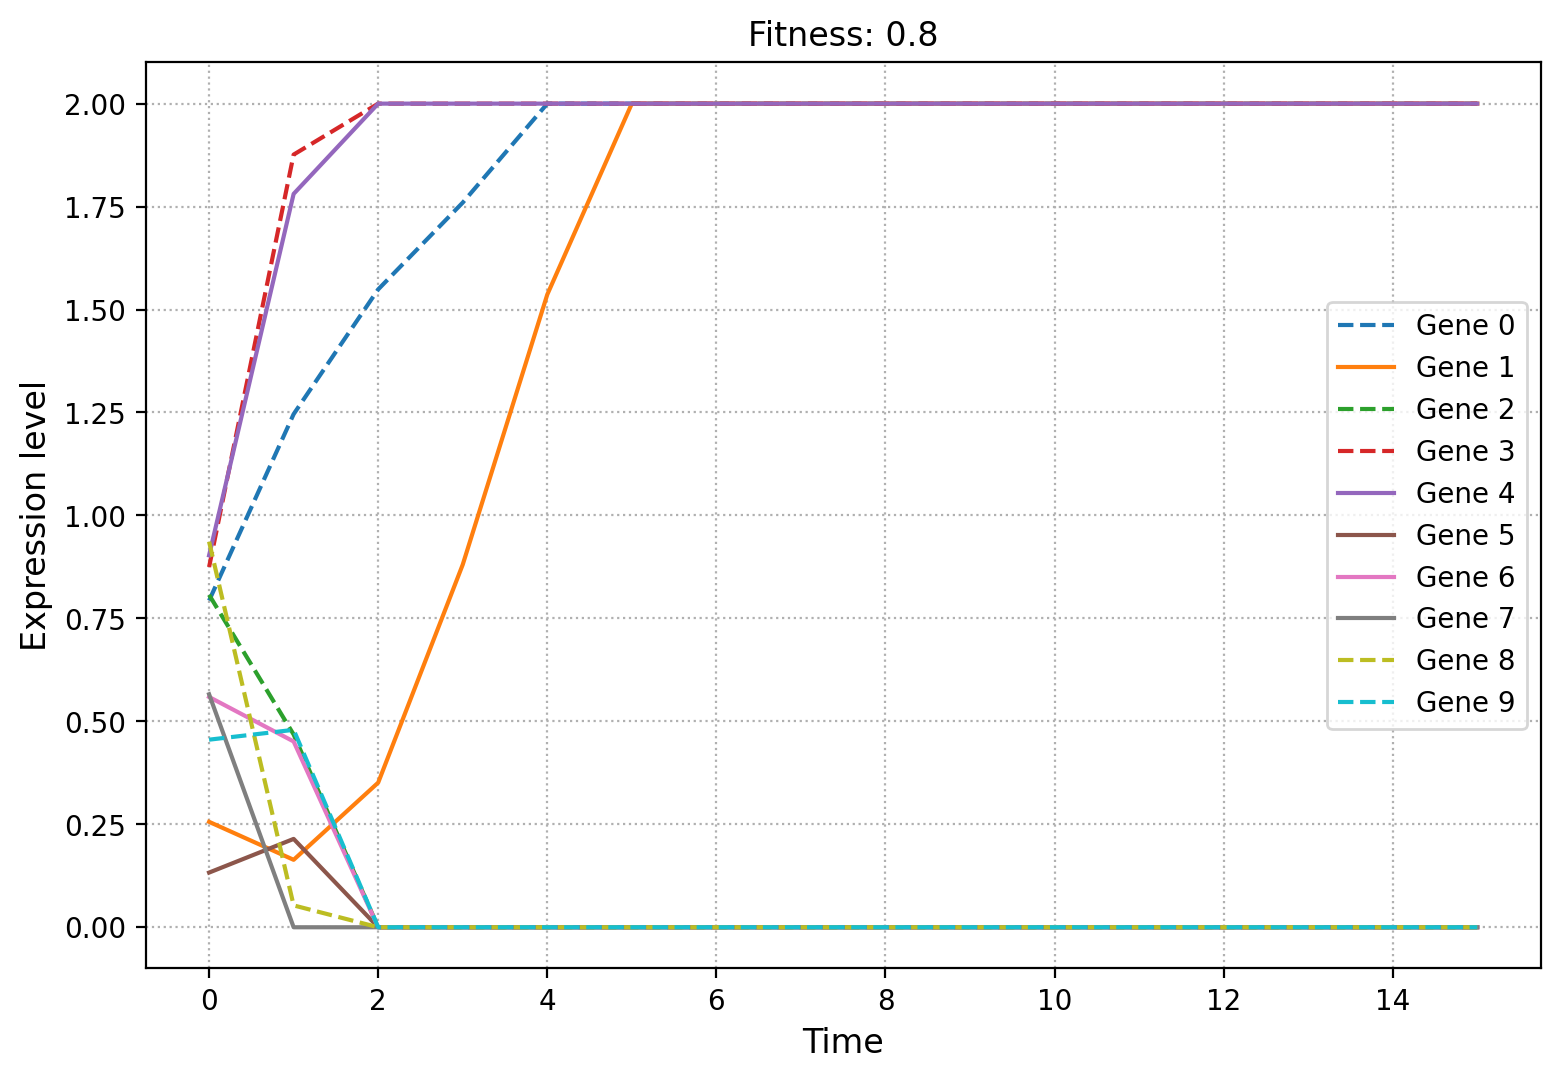

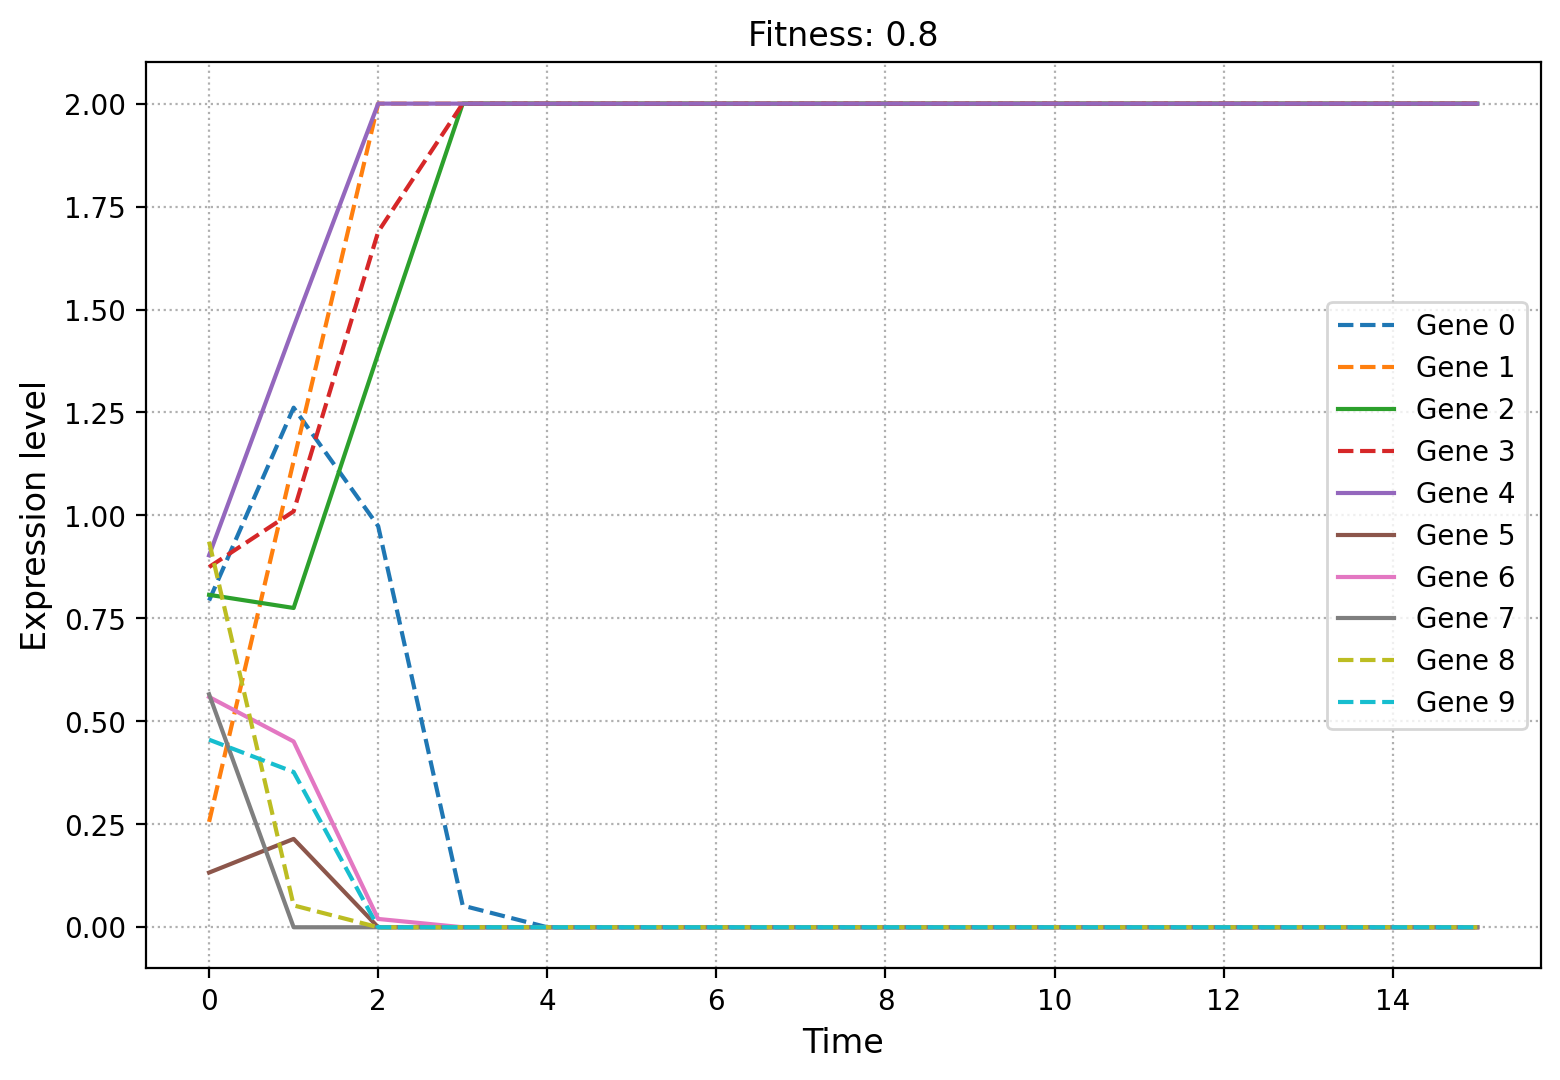

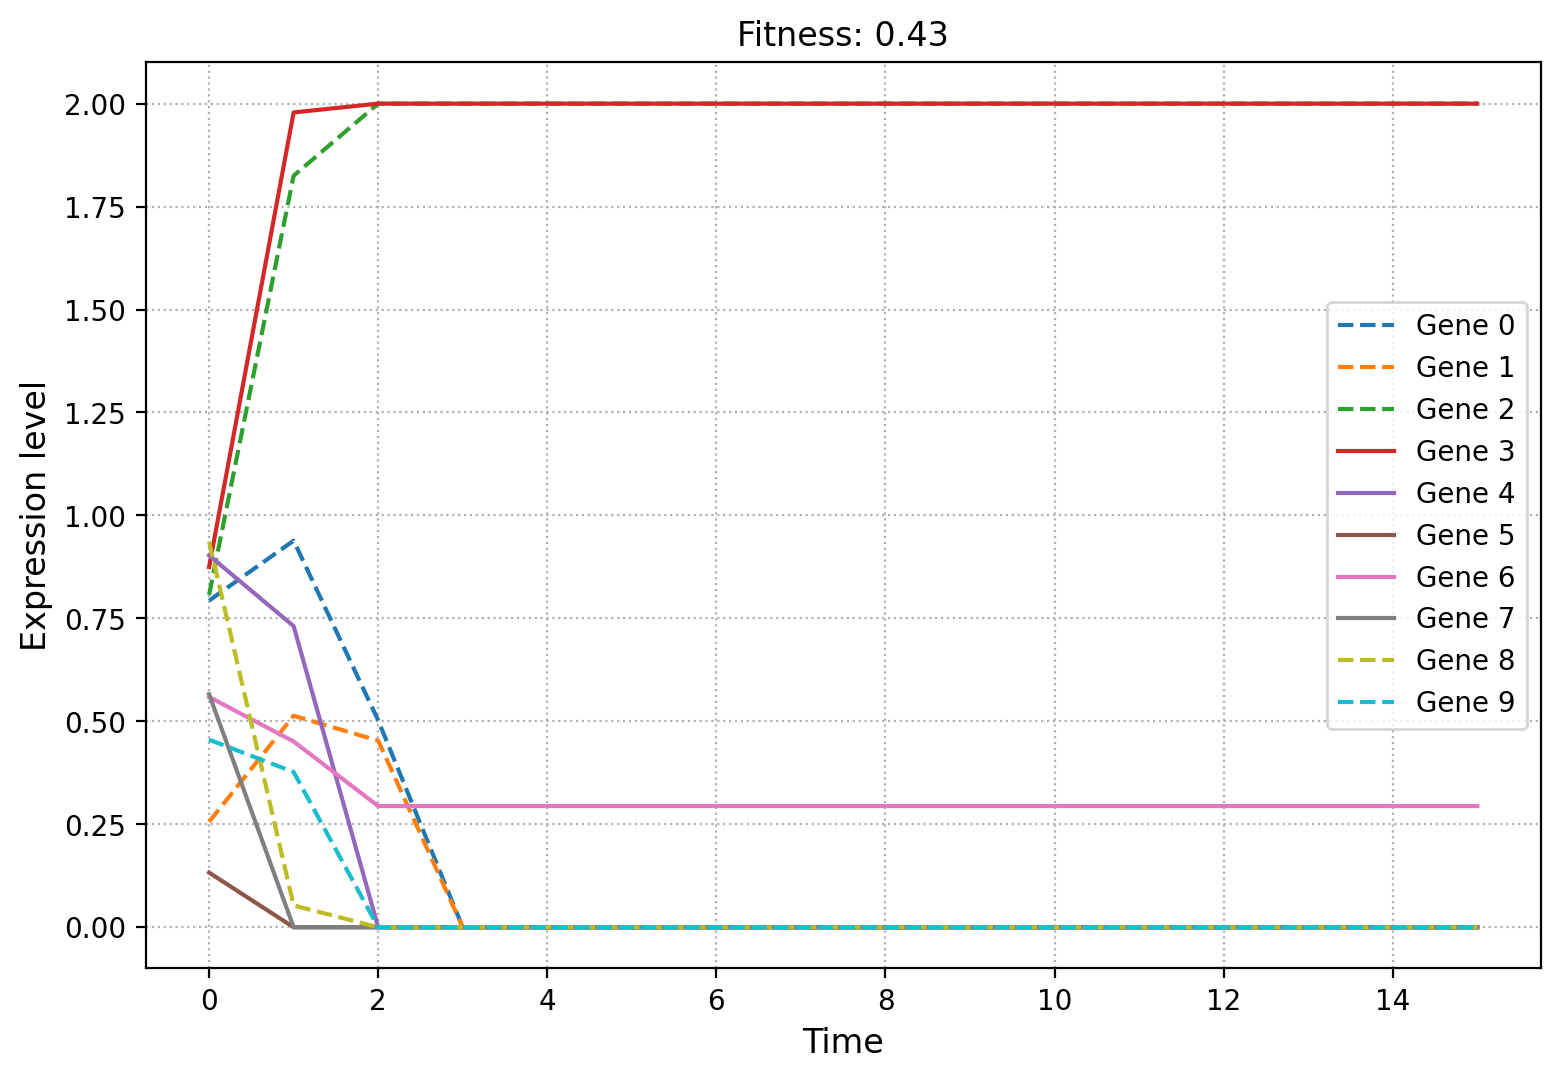

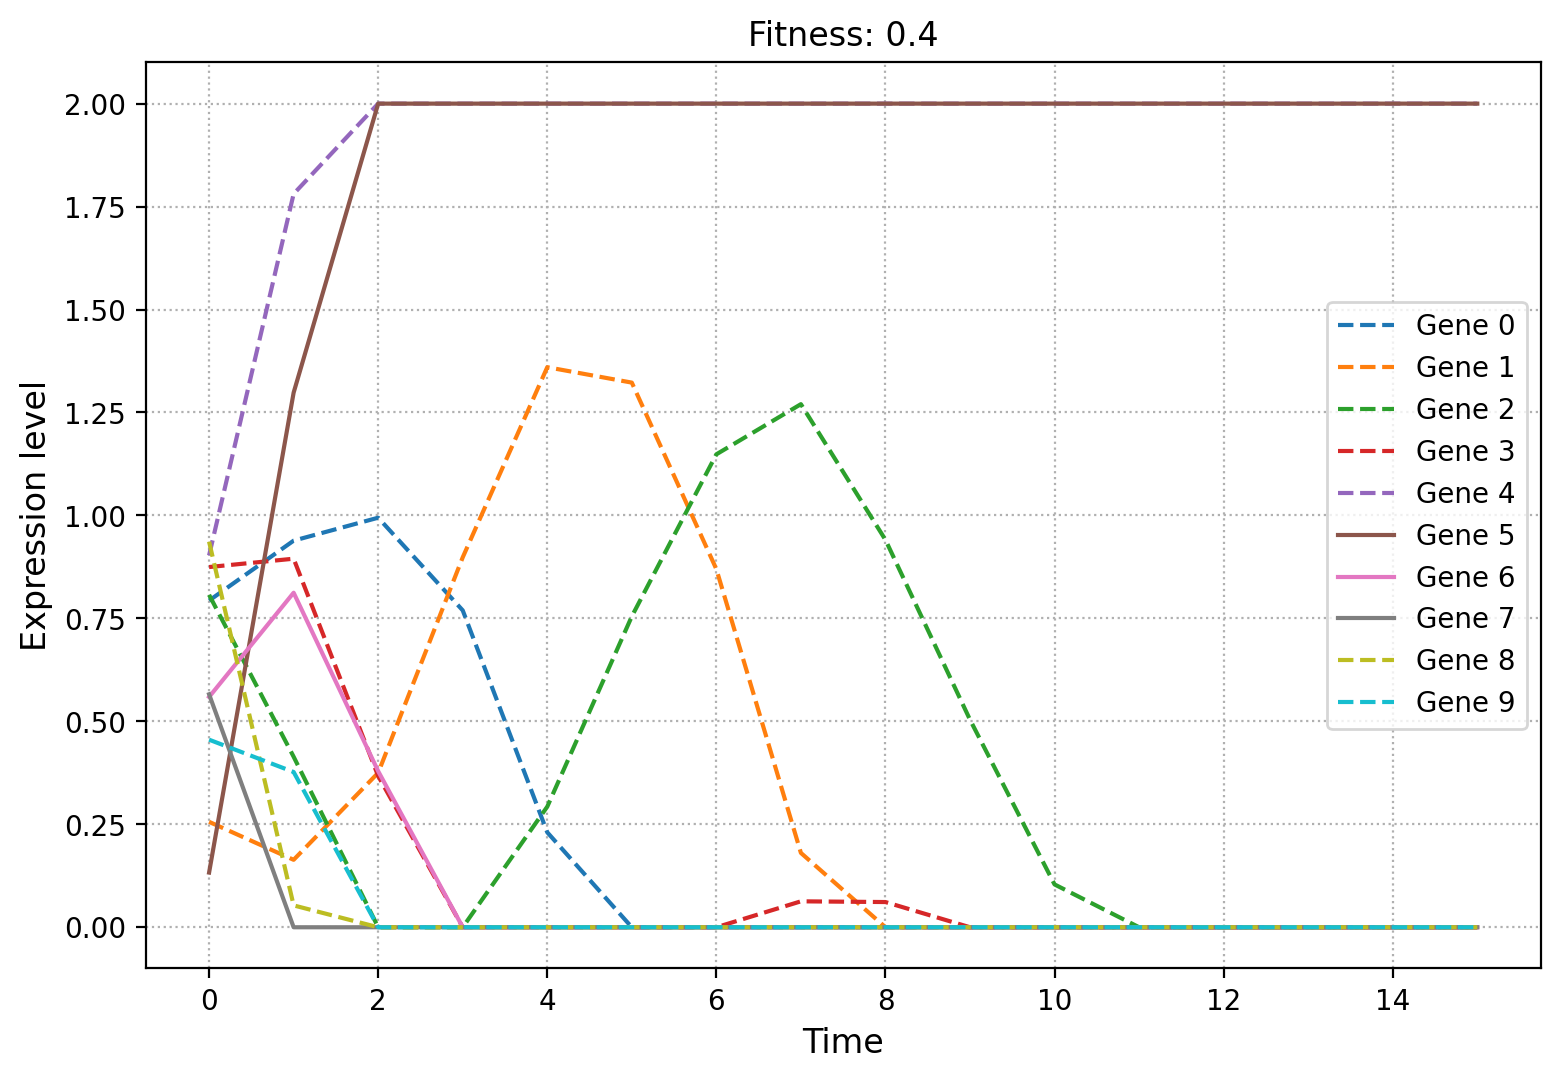

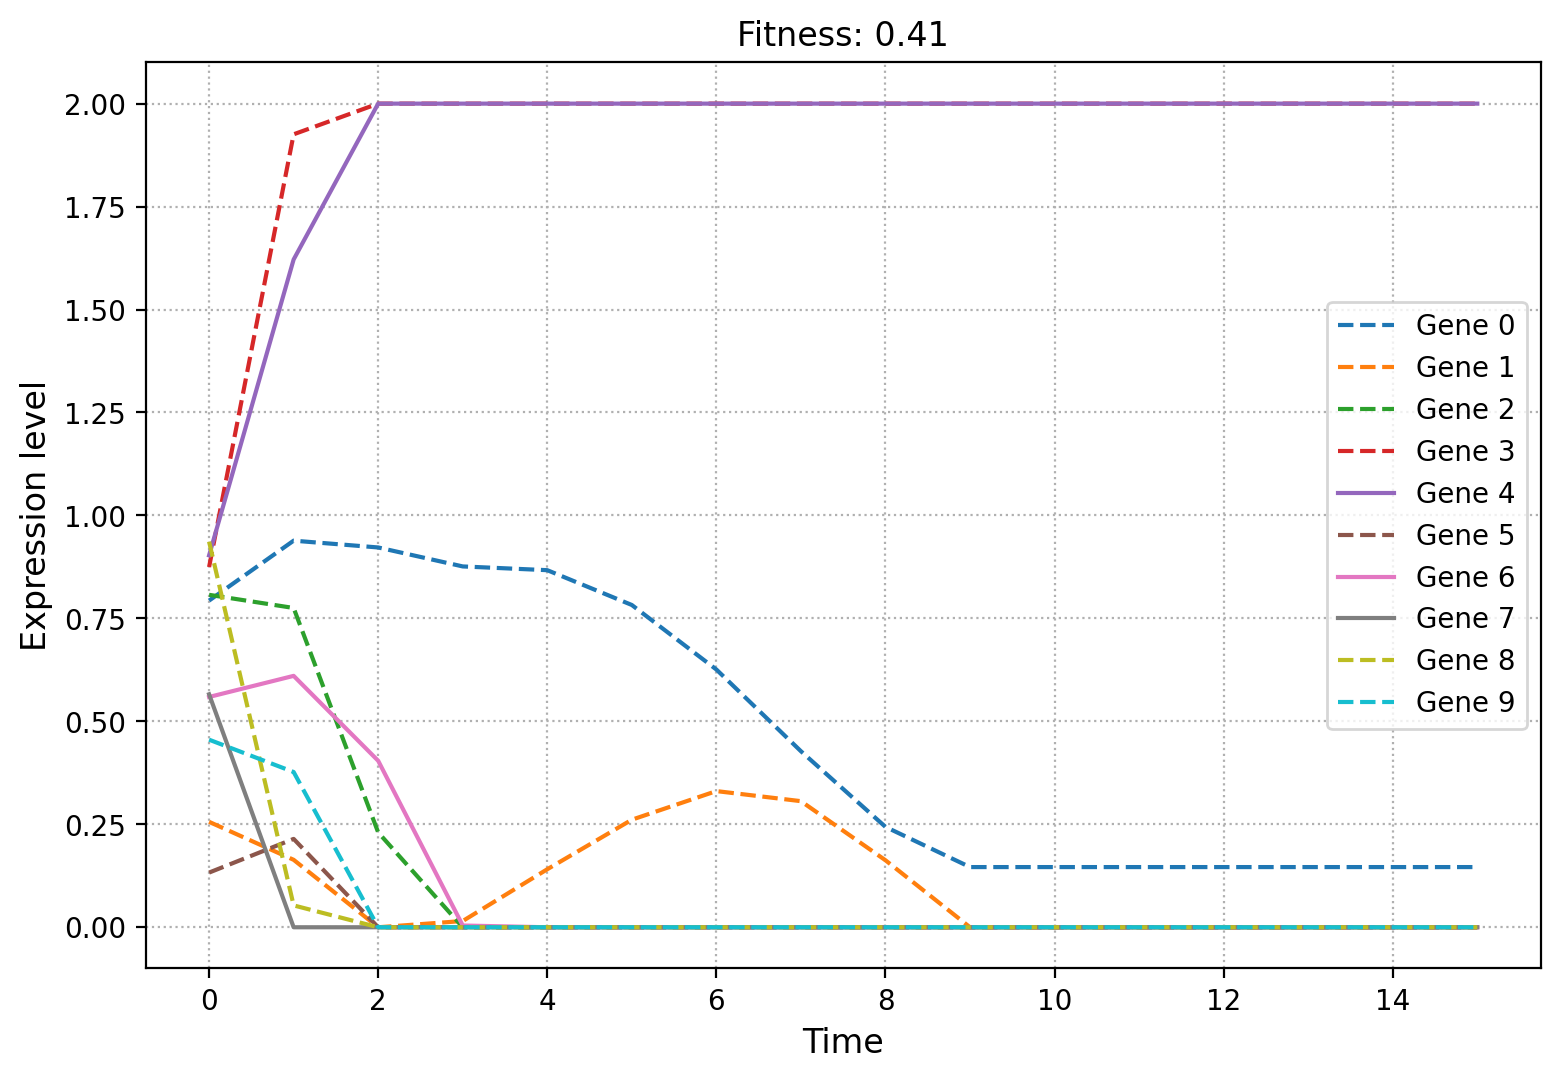

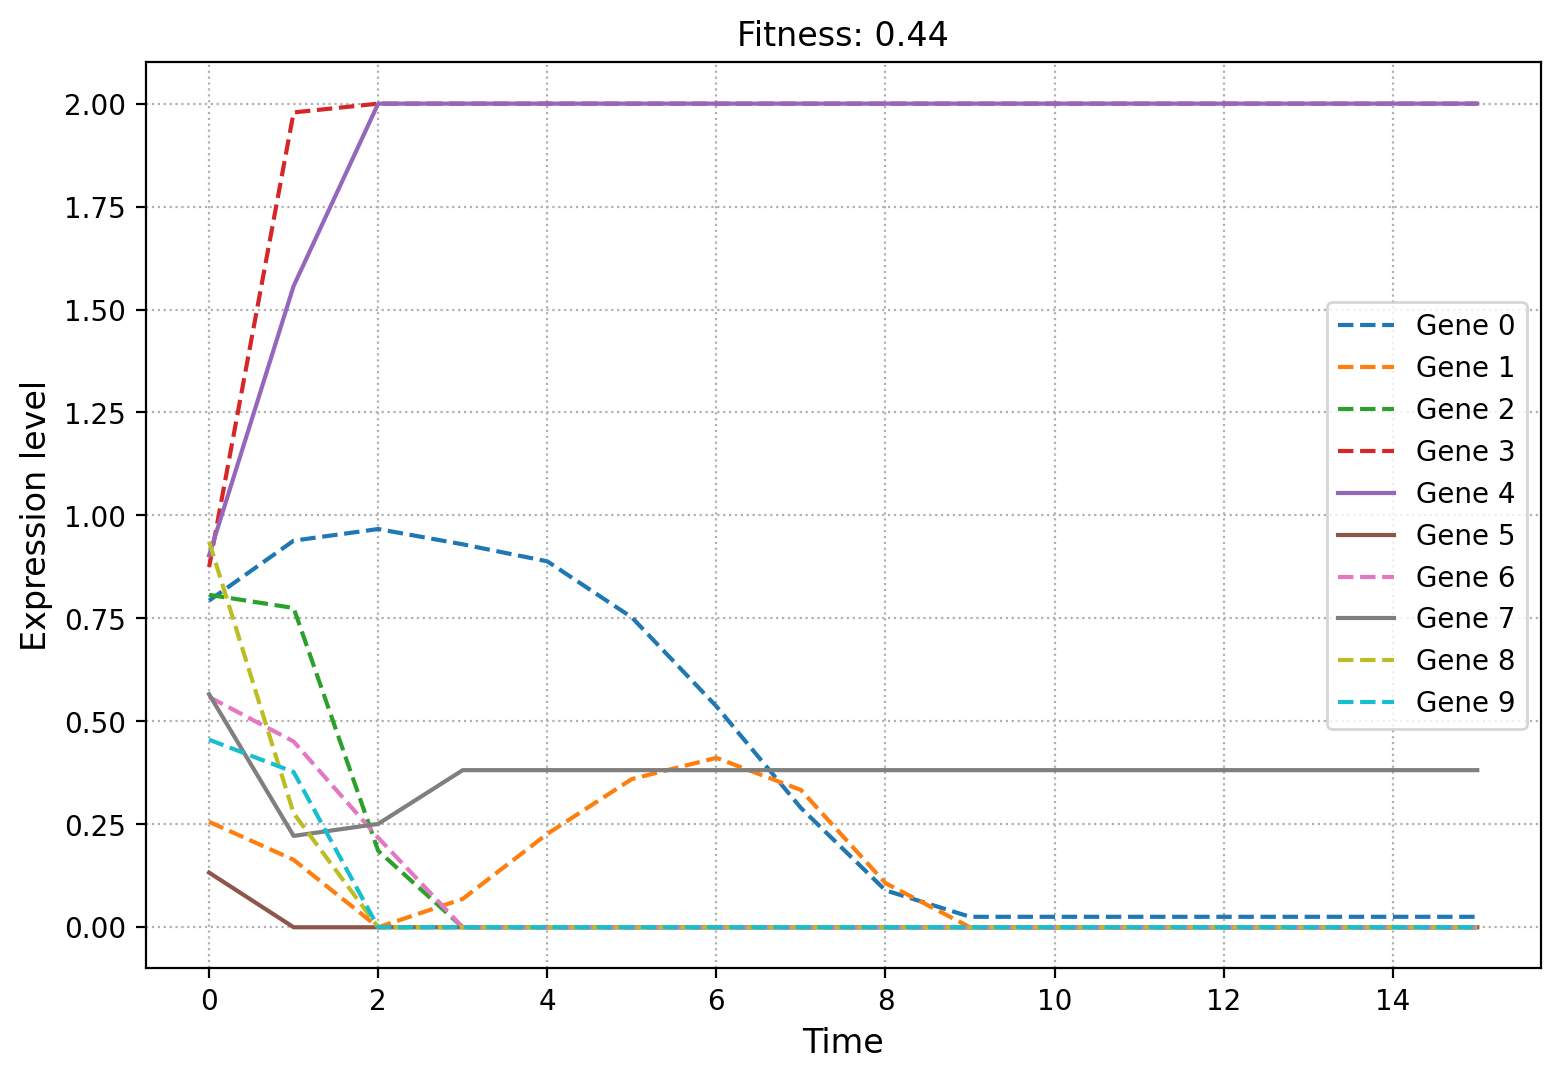

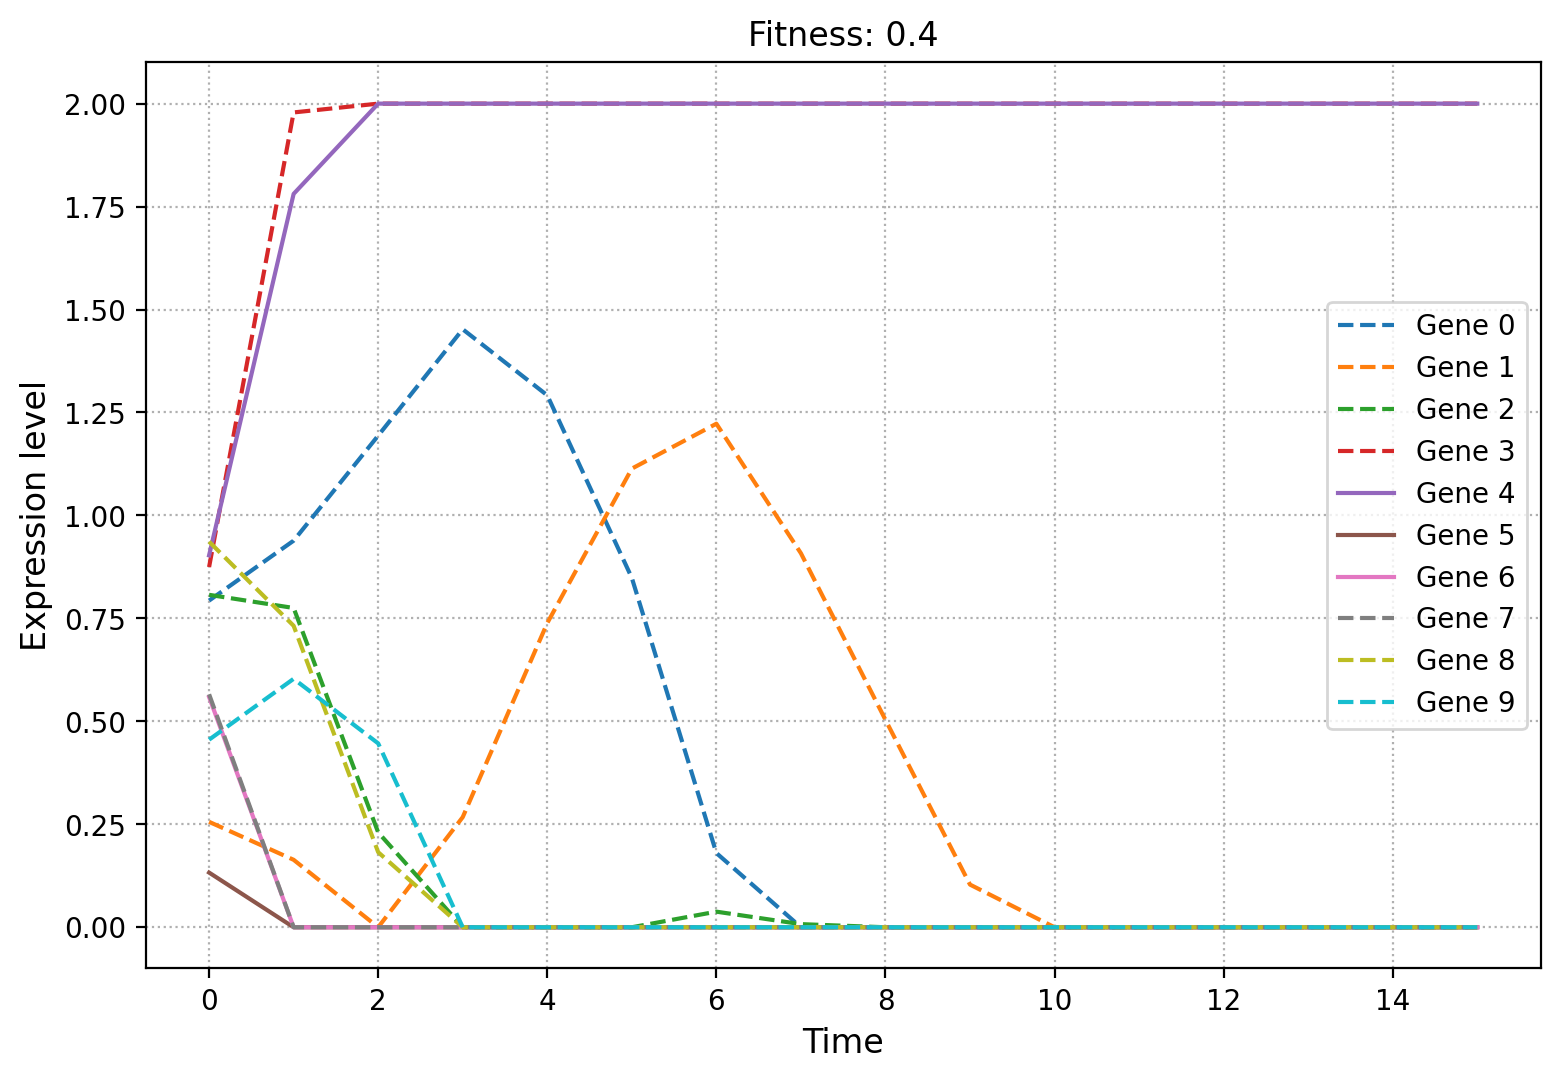

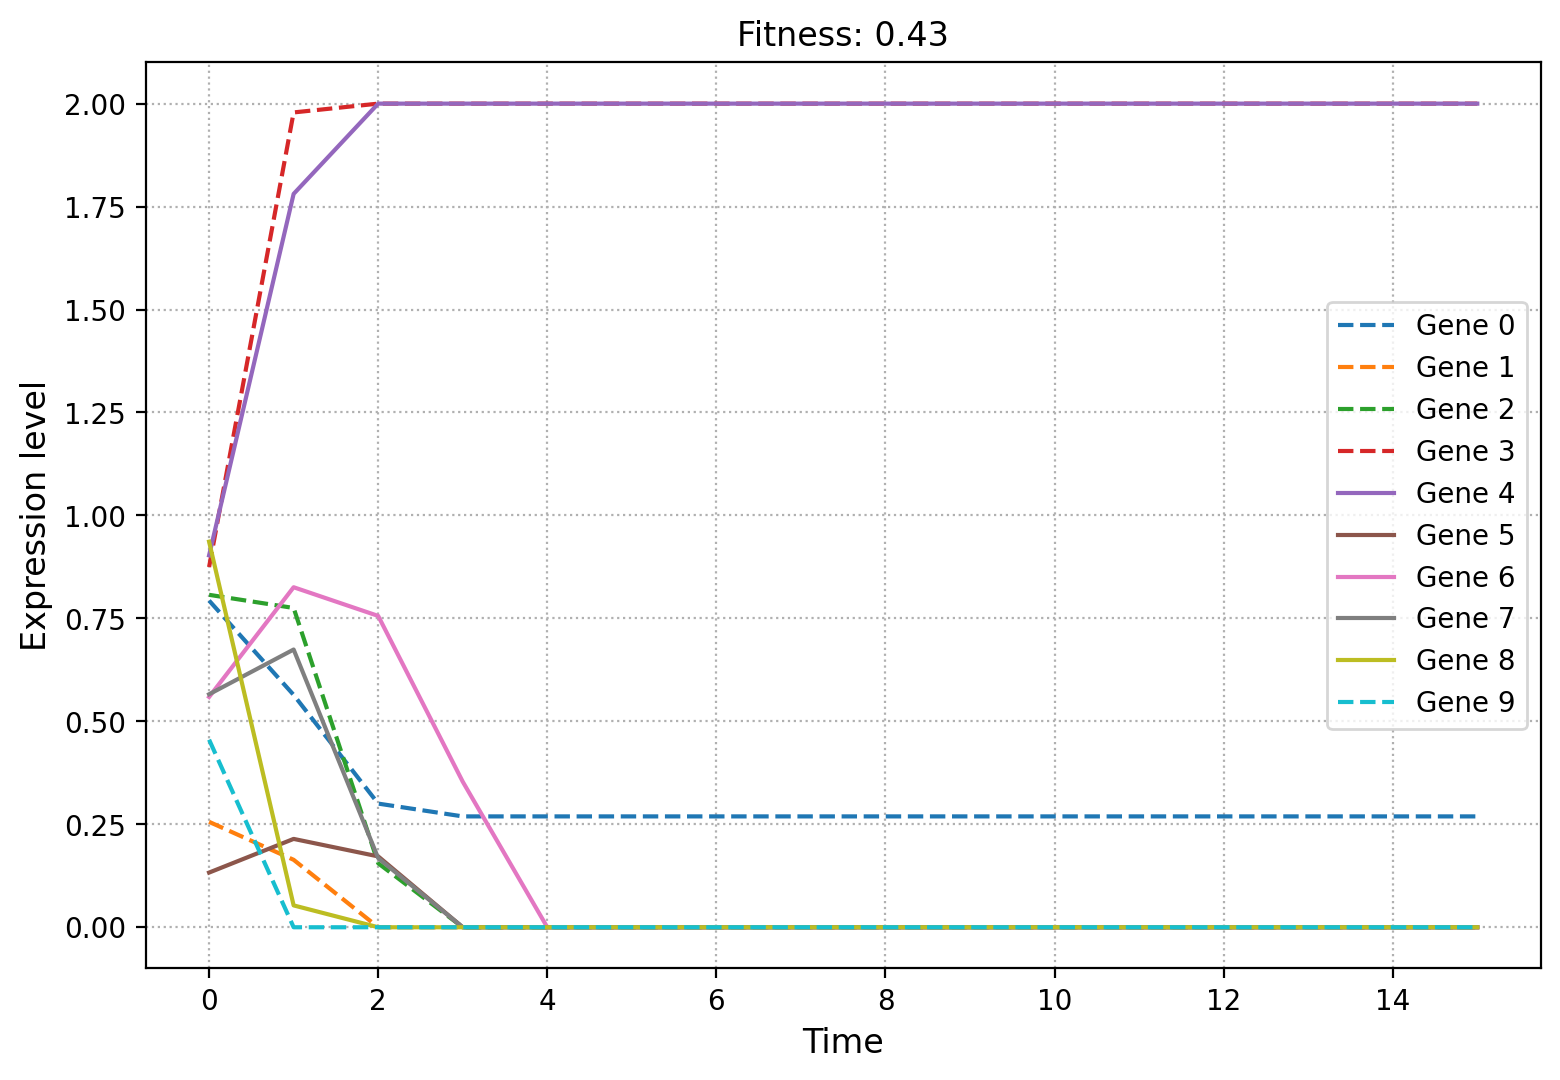

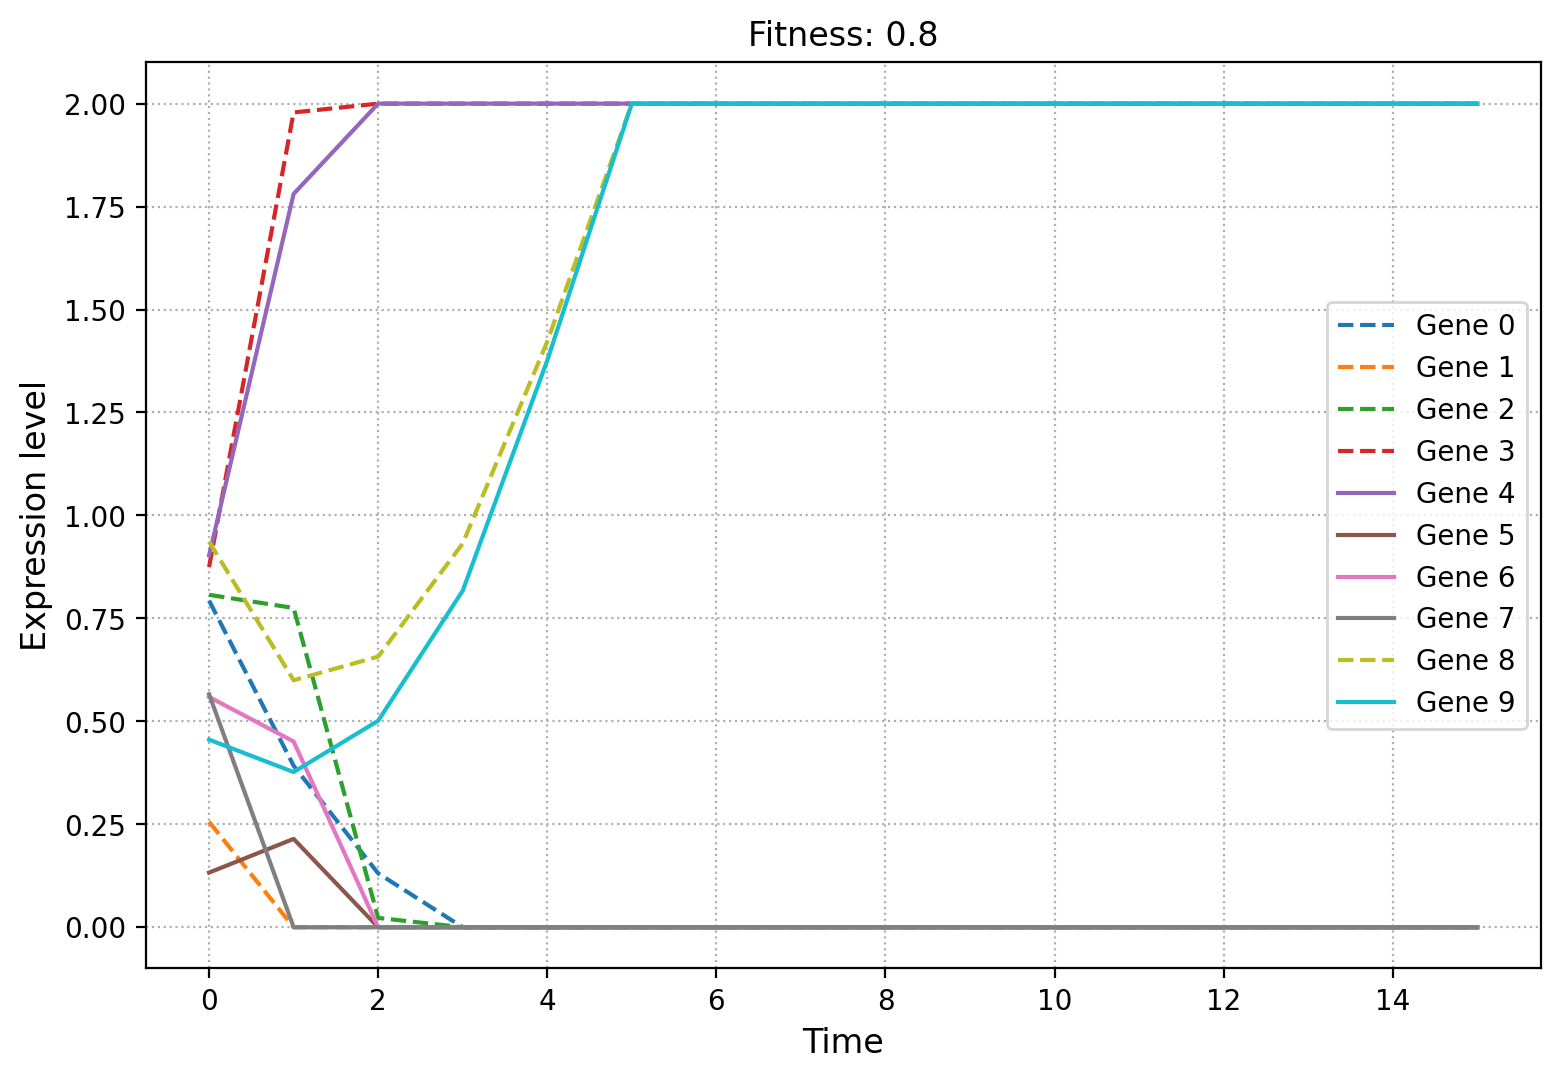

In [18]:
for i_switched_gene in range(len(genes)):
    # Switch the current gene 
    to_switch = genes[i_switched_gene]
    to_switch.orientation = 1 - to_switch.orientation
    
    # Run the switched system and plot
    switch_res, switch_fit = run_individual(genes, 16)
    print(f'Switched gene {i_switched_gene}, fitness: {switch_fit}')
    plot_expr(switch_res, switch_fit, f'switched_{i_switched_gene}')
    
    # Reset the gene to its former orientation
    to_switch.orientation = 1 - to_switch.orientation